<a href="https://colab.research.google.com/github/bernardes7/Paredes/blob/main/notebooks/Ablation_Study_Chroma_corpus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Components to test:
  MED: Median filtering (3×3 noise reduction)
  WHI: Frequency whitening (timbral balance)
  DEC: Harmonic decay (amplitude envelope)
  INH: Inharmonicity (string stiffness)
  ODD: Odd-harmonic boost (timbre character)
  RES: Body resonances (soundboard modes)

SECTION 0: BUILDING CACHES


Caching projects:   0%|          | 0/8 [00:00<?, ?it/s]


✓ 8 projects cached and ready

SECTION 1: COMPONENT ABLATION (Cosine similarity only)

Loading ablation results and statistics from disk...
Ablation results loaded.


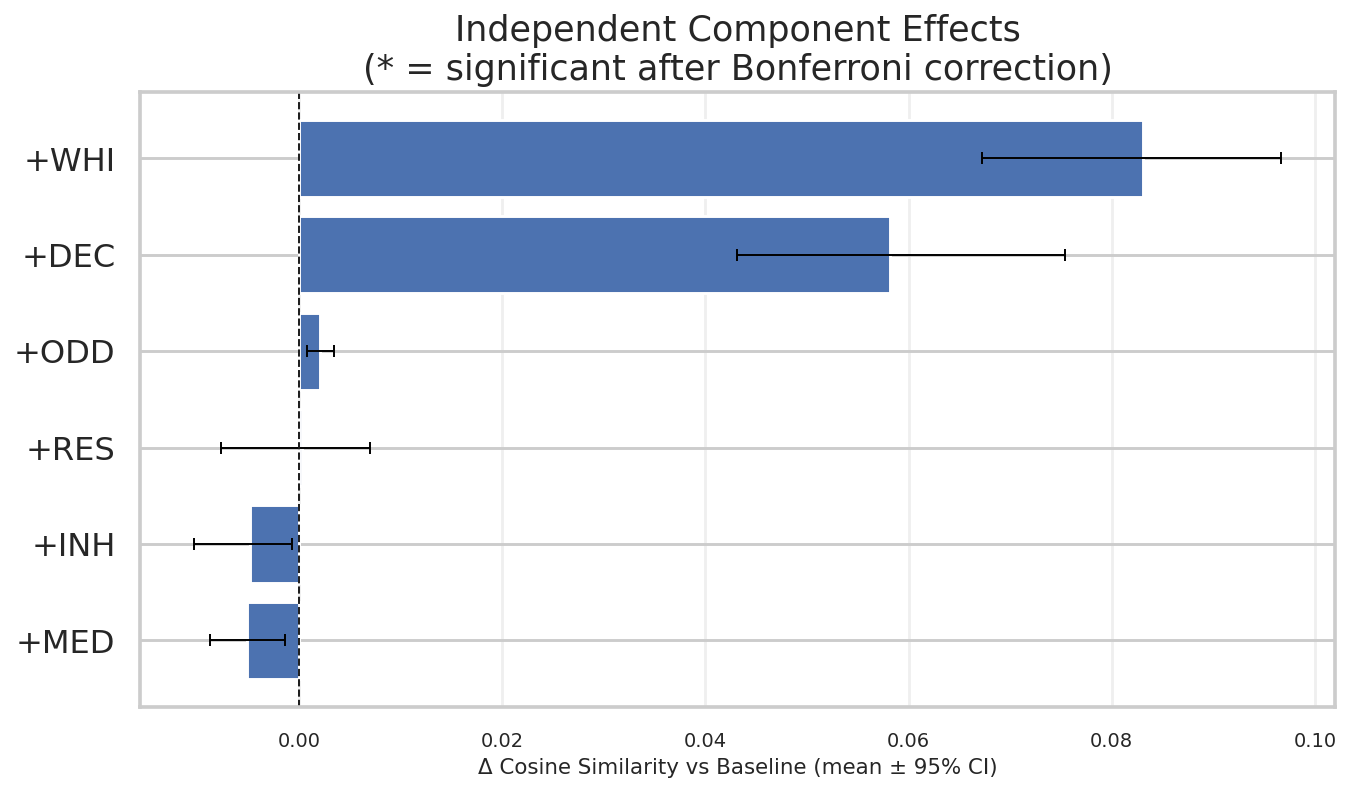


SECTION 2: PROGRESSIVE CONFIGURATION OPTIMIZATION (Cosine only)
✓ Loading existing progressive optimization results...

PROGRESSIVE CONFIGURATION COMPARISON

                      Configuration                              Description  Mean Cosine                             Optimized Params
        Config_B (+WHI+DEC+ODD+RES) Add Odd-harmonic boost + Body resonances     0.741418       detune_cents, s, gamma, res_gain_scale
Config_C (+WHI+DEC+ODD+RES+INH+MED)             Full model (MED + INH added)     0.738602 detune_cents, s, beta, gamma, res_gain_scale
                Config_A (+WHI+DEC)                        Whitening + Decay     0.738572                              detune_cents, s

✓ BEST CONFIGURATION: Config_B (+WHI+DEC+ODD+RES)
  Description: Add Odd-harmonic boost + Body resonances
  Performance (Mean Cosine): 0.7414


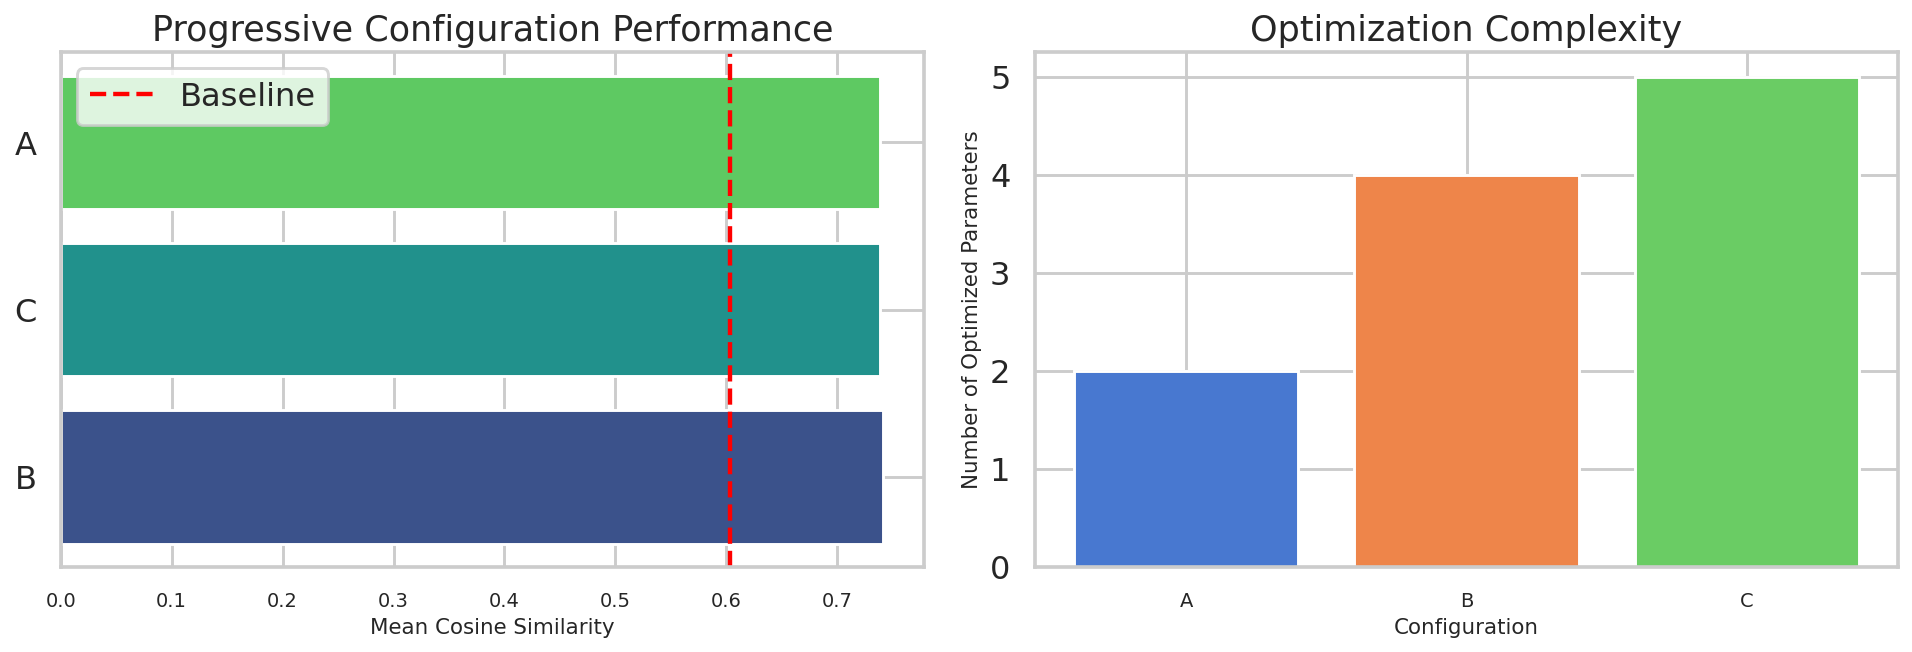


✓ Visualization saved to /content/drive/MyDrive/Between Voices/Corpus de Colaborações/_Ablation_Rigorous/progressive_comparison.png

SECTION 3: FINAL EVALUATION (placeholder)
Evaluating: Config_B (+WHI+DEC+ODD+RES)
Optimal parameters: {'detune_cents': 0.0, 's': 0.5, 'gamma': 0.95, 'res_gain_scale': 1.4}

✓ ABLATION STUDY COMPLETE
✓ All results in: /content/drive/MyDrive/Between Voices/Corpus de Colaborações/_Ablation_Rigorous

Key files:
  - ablation_results.csv (component ablation, cosine only)
  - ablation_statistics.csv (paired Δ cosine vs baseline)
  - progressive_optimization_results.json (optimized configs)
  - progressive_comparison.png (visualization)


In [21]:
"""
Ablation chroma - corpus
"""

# =========================
# Colab environment setup
# =========================
!pip -q install librosa==0.10.1 scipy numpy matplotlib pandas seaborn scikit-optimize tqdm

import os, json, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass, asdict
from pathlib import Path

# Fixed imports
import librosa
from scipy.ndimage import convolve1d, median_filter
from scipy.optimize import nnls
from scipy.stats import wilcoxon, ttest_rel

from skopt import Optimizer
from skopt.space import Real
from tqdm.auto import tqdm  # progress bars

# Plot style
sns.set_theme(context="talk", style="whitegrid", palette="deep")
plt.rcParams.update({"figure.dpi": 140, "axes.labelsize": 11, "xtick.labelsize": 10})
np.set_printoptions(precision=4, suppress=True)
np.random.seed(42)

# Google Drive mount (Colab-only)
from google.colab import drive
drive.mount('/content/drive')

# =========================
# Paths and corpus selection
# =========================
BASE_DIR = '/content/drive/MyDrive/Between Voices/Corpus de Colaborações'
BASE = Path(BASE_DIR)

SELECTED_PROJECTS = [
    '1958_Augusto Camacho/Quando os Sinos Dobram',
    '1958_Augusto Camacho/Adeus a Coimbra',
    '1958_Augusto Camacho/Água da Fonte',
    '1958_Augusto Camacho/A Luz do Teu Olhar',
    '1970_Cecília de Melo/Não Choro por me Deixares',
    '1970_Cecília de Melo/O Render dos Heróis',
    '1967_Luiz Goes/Balada do Mar',
    '1967_Luiz Goes/Canção da Infância',
]

# =========================
# DSP & model constants
# =========================
N_FFT, HOP_LENGTH = 2048, 512
BINS_PER_OCTAVE, N_OCTAVES = 36, 5
FMIN_NOTE = 'A0'
MAX_HARMONICS = 20
SPREAD_SEMITONES = 0.35
CHROMA_THRESHOLD = 0.02
BODY_RESONANCES = [(120.0, 30.0, 0.9), (470.0, 80.0, 0.7), (1000.0, 150.0, 0.5)]

COMPONENTS = {
    'MED': 'Median filtering (3×3 noise reduction)',
    'WHI': 'Frequency whitening (timbral balance)',
    'DEC': 'Harmonic decay (amplitude envelope)',
    'INH': 'Inharmonicity (string stiffness)',
    'ODD': 'Odd-harmonic boost (timbre character)',
    'RES': 'Body resonances (soundboard modes)'
}

# Unified parameter search space
PARAM_SPACE = {
    'detune_cents': (0.0, 7.0),
    's': (0.50, 0.70),
    'beta': (0.5e-4, 6e-4),
    'gamma': (0.95, 1.35),
    'res_gain_scale': (0.6, 1.4)
}

print("Components to test:")
for k, v in COMPONENTS.items():
    print(f"  {k}: {v}")

# =========================
# Statistical helpers
# =========================
def bootstrap_ci(data, stat_fn=np.mean, n_boot=5000, ci=95):
    """Bootstrap confidence interval"""
    data = np.array(data)
    data = data[~np.isnan(data)]
    if len(data) == 0:
        return np.nan, (np.nan, np.nan)
    rng = np.random.default_rng(42)
    boots = np.array([stat_fn(rng.choice(data, size=len(data), replace=True))
                      for _ in range(n_boot)])
    alpha = (100 - ci) / 2
    lower = np.percentile(boots, alpha)
    upper = np.percentile(boots, 100 - alpha)
    return float(stat_fn(data)), (float(lower), float(upper))

def cohen_d(x, y):
    """Effect size (Cohen's d) for paired samples"""
    x, y = np.array(x), np.array(y)
    diff = x - y
    return float(np.mean(diff) / (np.std(diff, ddof=1) + 1e-8))

def paired_test(x, y, test='wilcoxon'):
    """Paired statistical test (Wilcoxon or t-test)"""
    x, y = np.array(x), np.array(y)
    mask = ~(np.isnan(x) | np.isnan(y))
    x, y = x[mask], y[mask]
    if len(x) < 3:
        return np.nan
    try:
        if test == 'wilcoxon':
            _, p = wilcoxon(x, y, alternative='two-sided')
        else:
            _, p = ttest_rel(x, y)
        return float(p)
    except Exception:
        return np.nan

def bonferroni_correction(p_values, alpha=0.05):
    """Bonferroni correction for multiple comparisons"""
    n_tests = len([p for p in p_values if not np.isnan(p)])
    return alpha / n_tests if n_tests > 0 else alpha

# =========================
# Core model functions
# =========================
@dataclass
class Params:
    sr: int
    use_median: bool = False
    use_whitening: bool = False
    s: float = 0.60
    beta: float = 2e-4
    detune_cents: float = 3.0
    gamma: float = 1.15

def hpss(y, sr):
    """HPSS with fallback"""
    try:
        return librosa.effects.hpss(y, margin=(1.0, 6.0), power=2.0)[0]
    except Exception:
        S = librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH, window='hann')
        H = librosa.decompose.hpss(np.abs(S), margin=(1.0, 6.0), power=2.0)[0]
        return librosa.istft(H * np.exp(1j * np.angle(S)), hop_length=HOP_LENGTH)

def compute_cqt(y, sr):
    """Compute raw CQT"""
    fmin = librosa.note_to_hz(FMIN_NOTE)
    C = np.abs(librosa.cqt(
        y, sr=sr, hop_length=HOP_LENGTH,
        bins_per_octave=BINS_PER_OCTAVE,
        n_bins=BINS_PER_OCTAVE * N_OCTAVES,
        fmin=fmin
    )).astype(np.float32)
    freqs = librosa.cqt_frequencies(C.shape[0], fmin=fmin, bins_per_octave=BINS_PER_OCTAVE)
    return C, freqs, fmin

def apply_median(C):
    """Apply median filtering"""
    return median_filter(C, size=(3, 3))

def apply_whitening(C):
    """
    Vectorized frequency whitening:
    - moving mean & std across pitch axis using 1D convolution
    - no per-frame Python loop
    """
    win_len = int(round(0.5 * BINS_PER_OCTAVE))
    if win_len % 2 == 0:
        win_len += 1
    kernel = np.hamming(win_len).astype(np.float32)
    kernel /= kernel.sum()

    # Convolve along frequency axis (axis=0) for the entire matrix
    mu = convolve1d(C, kernel, axis=0, mode='reflect')
    var = convolve1d((C - mu)**2, kernel, axis=0, mode='reflect')
    sigma = np.sqrt(var)

    C_out = (C - mu) / np.maximum(sigma, 1e-8)
    # Half-wave rectification to suppress negative residuals
    C_out = np.maximum(C_out, 0.0).astype(np.float32)
    return C_out

def build_dictionary(freqs, fmin, p, use_dec, use_inh, use_odd, use_res, res_scale=1.0):
    """Build physics-informed dictionary"""
    pos = np.log2(freqs / fmin) * 12
    sig = SPREAD_SEMITONES
    notes = librosa.midi_to_hz(np.arange(21, 21 + N_OCTAVES * 12))
    E = np.zeros((len(freqs), len(notes)), dtype=np.float32)
    dr = (2**(p.detune_cents / 1200) - 1)

    for j, f0 in enumerate(notes):
        col = np.zeros(len(freqs), dtype=np.float32)
        for k in range(1, MAX_HARMONICS + 1):
            fk = f0 * k * np.sqrt(1 + p.beta * k**2) if use_inh else f0 * k
            if fk > freqs[-1] * 1.001:
                break
            ak = (p.s**(k - 1)) if use_dec else 1.0
            if use_odd and k % 2 == 1:
                ak *= p.gamma
            for d in (-dr, dr):
                tgt = np.log2(fk * (1 + d) / fmin) * 12
                col += (ak * np.exp(-0.5 * ((pos - tgt) / sig)**2)).astype(np.float32)
        nrm = np.linalg.norm(col)
        if nrm > 0:
            col /= nrm
        E[:, j] = col

    if use_res:
        bg = np.ones(len(freqs), dtype=np.float32)
        for f_res, width, gain in BODY_RESONANCES:
            bg += (gain * res_scale) * np.exp(-0.5 * ((freqs - f_res) / width)**2)
        E = E * bg[:, None]
        # Renormalize columns
        for j in range(E.shape[1]):
            nrm = np.linalg.norm(E[:, j])
            if nrm > 0:
                E[:, j] /= nrm
    return E

def nnls_decompose(C_proc, E):
    """NNLS decomposition to chroma"""
    notes = librosa.midi_to_hz(np.arange(21, 21 + N_OCTAVES * 12))
    acts = np.zeros((len(notes), C_proc.shape[1]), dtype=np.float32)
    for t in range(C_proc.shape[1]):
        acts[:, t], _ = nnls(E, C_proc[:, t])

    # Fold to 12-bin chroma
    midi = np.arange(21, 21 + len(notes))
    chroma = np.zeros((12, acts.shape[1]), dtype=np.float32)
    for j, pc in enumerate(midi % 12):
        chroma[pc, :] += acts[j, :]
    # Normalize per column and threshold
    chroma /= np.maximum(chroma.max(0, keepdims=True), 1e-8)
    chroma[chroma < CHROMA_THRESHOLD] = 0
    return chroma

def extract_chroma_from_cache(cache, p, use_med, use_whi, use_dec, use_inh, use_odd, use_res, res_scale=1.0):
    """Extract chroma from cached CQT"""
    C = cache['C'].copy()
    # Preprocessing
    if use_med:
        C = apply_median(C)
    if use_whi:
        C = apply_whitening(C)
    # Dictionary + NNLS
    E = build_dictionary(cache['freqs'], cache['fmin'], p, use_dec, use_inh, use_odd, use_res, res_scale)
    chroma = nnls_decompose(C, E)
    return chroma

def beat_sync(chroma_f, frame_times, beats):
    """Beat-synchronous aggregation (median)"""
    n = len(beats) - 1
    if n <= 0:
        raise ValueError("Need >= 2 beat boundaries")
    chroma_b = np.zeros((12, n), dtype=np.float32)
    for b in range(n):
        idx = np.where((frame_times >= beats[b]) & (frame_times < beats[b + 1]))[0]
        if len(idx) > 0:
            chroma_b[:, b] = np.median(chroma_f[:, idx], axis=1)
    chroma_b /= np.maximum(chroma_b.max(0, keepdims=True), 1e-8)
    chroma_b[chroma_b < CHROMA_THRESHOLD] = 0
    return chroma_b

# =========================
# Ground truth
# =========================
ROOT_MAP = {'C': 0, 'C#': 1, 'Db': 1, 'D': 2, 'D#': 3, 'Eb': 3, 'E': 4,
            'F': 5, 'F#': 6, 'Gb': 6, 'G': 7, 'G#': 8, 'Ab': 8, 'A': 9,
            'A#': 10, 'Bb': 10, 'B': 11, 'N': -1}

PATTERNS = {
    'maj':  [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
    'min':  [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
    '7':    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    'maj7': [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
    'min7': [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    '':     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
}

def label_to_chroma(lbl):
    """Convert chord label to chroma vector"""
    if lbl == 'N':
        return np.zeros(12)
    parts = lbl.strip().split()
    root = ROOT_MAP.get(parts[0] if parts else '', -1)
    qual = ' '.join(parts[1:]).lower() if len(parts) > 1 else ''
    pat = np.array(PATTERNS.get(qual, PATTERNS['']))
    return np.roll(pat, root) if root != -1 else np.zeros(12)

def build_gt_beats(beats, chord_times, chord_labels):
    """Build beat-synchronous ground truth"""
    intervals = np.append(chord_times, chord_times[-1] + 10)
    n = len(beats) - 1
    gt = np.zeros((12, n), dtype=np.float32)
    for b in range(n):
        mid = 0.5 * (beats[b] + beats[b + 1])
        idx = np.searchsorted(intervals, mid, side='right') - 1
        if 0 <= idx < len(chord_labels):
            gt[:, b] = label_to_chroma(chord_labels[idx]).astype(np.float32)
    return gt

# =========================
# Evaluation (cosine only)
# =========================
def cosine_similarity(est, gt):
    """Mean cosine similarity (beat-synchronous)"""
    T = min(est.shape[1], gt.shape[1])
    est, gt = est[:, :T], gt[:, :T]
    eps = 1e-8
    en = est / (np.linalg.norm(est, axis=0, keepdims=True) + eps)
    gn = gt  / (np.linalg.norm(gt,  axis=0, keepdims=True) + eps)
    return float(np.mean(np.sum(en * gn, axis=0)))

# =========================
# SECTION 0: Build/Load caches (with progress bar)
# =========================
def build_cache_for_project(proj_name):
    """Build and save cache for one project"""
    proj = BASE / proj_name
    guitars = proj / 'guitars.wav'
    full = proj / 'full_audio.m4a'
    y, sr = None, None
    if guitars.exists():
        y, sr = librosa.load(str(guitars), sr=None, mono=True)
    elif full.exists():
        y, sr = librosa.load(str(full), sr=None, mono=True)
    if y is None:
        print(f"[Skip] {proj_name}: no audio")
        return None
    y = np.nan_to_num(y, nan=0, posinf=0, neginf=0)

    beats_f = proj / 'beats.txt'
    chords_f = proj / 'chords.txt'
    if not beats_f.exists() or not chords_f.exists():
        print(f"[Skip] {proj_name}: missing beats/chords")
        return None

    beats = pd.read_csv(beats_f, sep='\t', header=None, names=['time', 'pos'])['time'].values.astype(np.float32)
    chords_df = pd.read_csv(chords_f, sep='\t', header=None, names=['time', 'label'])
    chord_times = chords_df['time'].values.astype(np.float32)
    chord_labels = chords_df['label'].astype(str).tolist()

    if len(beats) < 2:
        print(f"[Skip] {proj_name}: < 2 beats")
        return None

    # Compute HPSS & CQT
    y_harm = hpss(y, sr)
    C, freqs, fmin = compute_cqt(y_harm, sr)

    frame_times = librosa.frames_to_time(np.arange(C.shape[1]), sr=sr, hop_length=HOP_LENGTH)
    gt_beats = build_gt_beats(beats, chord_times, chord_labels)

    cache = {
        'sr': sr,
        'C': C,
        'freqs': freqs,
        'fmin': fmin,
        'frame_times': frame_times,
        'beats': beats,
        'gt_beats': gt_beats,
        'project': proj_name
    }

    cache_dir = proj / 'ablation_cache'
    cache_dir.mkdir(exist_ok=True)
    cache_path = cache_dir / 'cache.pkl'
    with open(cache_path, 'wb') as f:
        pickle.dump(cache, f)
    return cache

def load_cache(proj_name):
    """Load cached data"""
    cache_path = BASE / proj_name / 'ablation_cache' / 'cache.pkl'
    if cache_path.exists():
        with open(cache_path, 'rb') as f:
            return pickle.load(f)
    return None

print("\n" + "="*80)
print("SECTION 0: BUILDING CACHES")
print("="*80)
caches = {}
for proj in tqdm(SELECTED_PROJECTS, desc="Caching projects"):
    cache = load_cache(proj)
    if cache is None:
        cache = build_cache_for_project(proj)
    if cache is not None:
        caches[proj] = cache
print(f"\n✓ {len(caches)} projects cached and ready")
if len(caches) == 0:
    raise RuntimeError("No valid caches built")

# =========================
# SECTION 1: Component ablation (cosine only) with progress bars
# =========================
print("\n" + "="*80)
print("SECTION 1: COMPONENT ABLATION (Cosine similarity only)")
print("="*80)

base_params = Params(sr=22050, s=0.60, beta=2e-4, detune_cents=3.0, gamma=1.15)

configs = {
    'Baseline': {'use_med': False, 'use_whi': False, 'use_dec': False,
                 'use_inh': False, 'use_odd': False, 'use_res': False},

    # Individual components
    '+MED': {'use_med': True, 'use_whi': False, 'use_dec': False,
             'use_inh': False, 'use_odd': False, 'use_res': False},
    '+WHI': {'use_med': False, 'use_whi': True, 'use_dec': False,
             'use_inh': False, 'use_odd': False, 'use_res': False},
    '+DEC': {'use_med': False, 'use_whi': False, 'use_dec': True,
             'use_inh': False, 'use_odd': False, 'use_res': False},
    '+INH': {'use_med': False, 'use_whi': False, 'use_dec': False,
             'use_inh': True, 'use_odd': False, 'use_res': False},
    '+ODD': {'use_med': False, 'use_whi': False, 'use_dec': False,
             'use_inh': False, 'use_odd': True, 'use_res': False},
    '+RES': {'use_med': False, 'use_whi': False, 'use_dec': False,
             'use_inh': False, 'use_odd': False, 'use_res': True},

    # Key pairwise requested
    '+WHI+DEC': {'use_med': False, 'use_whi': True, 'use_dec': True,
                 'use_inh': False, 'use_odd': False, 'use_res': False},
}

out_dir = BASE / '_Ablation_Rigorous'
out_dir.mkdir(exist_ok=True)
ablation_results_path = out_dir / 'ablation_results.csv'
ablation_stats_path = out_dir / 'ablation_statistics.csv'

if ablation_results_path.exists() and ablation_stats_path.exists():
    print("\nLoading ablation results and statistics from disk...")
    df_ablation = pd.read_csv(ablation_results_path)
    df_stats = pd.read_csv(ablation_stats_path)
    alpha_corrected = bonferroni_correction(df_stats['p-value'].values)
    print("Ablation results loaded.")
else:
    print("\nComputing ablation results...")
    results = []
    cfg_iter = tqdm(configs.items(), total=len(configs), desc="Configs")
    for cfg_name, toggles in cfg_iter:
        proj_iter = tqdm(caches.items(), total=len(caches), desc=f"{cfg_name} - projects", leave=False)
        for proj_name, cache in proj_iter:
            params_dict = asdict(base_params)
            params_dict['sr'] = cache['sr']
            p = Params(**params_dict)
            chroma_f = extract_chroma_from_cache(
                cache, p,
                toggles['use_med'], toggles['use_whi'],
                toggles['use_dec'], toggles['use_inh'],
                toggles['use_odd'], toggles['use_res']
            )
            chroma_b = beat_sync(chroma_f, cache['frame_times'], cache['beats'])
            cos = cosine_similarity(chroma_b, cache['gt_beats'])
            results.append({'config': cfg_name, 'project': proj_name, 'cosine': cos})
    df_ablation = pd.DataFrame(results)

    # Paired stats vs Baseline (cosine only)
    print("\n" + "="*80)
    print("INDEPENDENT COMPONENT RESULTS (Δ cosine vs Baseline)")
    print("="*80)
    baseline_data = df_ablation[df_ablation['config'] == 'Baseline']
    stat_results = []
    for cfg in configs.keys():
        if cfg == 'Baseline':
            continue
        cfg_data = df_ablation[df_ablation['config'] == cfg]
        merged = baseline_data.merge(cfg_data, on='project', suffixes=('_base', '_cfg'))

        delta_cos = merged['cosine_cfg'] - merged['cosine_base']
        mean_cos, (ci_low, ci_high) = bootstrap_ci(delta_cos)
        p_val = paired_test(merged['cosine_cfg'], merged['cosine_base'])
        effect = cohen_d(merged['cosine_cfg'], merged['cosine_base'])

        stat_results.append({
            'Config': cfg, 'Δ Cosine': mean_cos,
            'CI_low': ci_low, 'CI_high': ci_high,
            'p-value': p_val, "Cohen's d": effect, 'n': len(merged)
        })

    df_stats = pd.DataFrame(stat_results).sort_values('Δ Cosine', ascending=False)
    alpha_corrected = bonferroni_correction(df_stats['p-value'].values)
    df_stats['Significant'] = df_stats['p-value'] < alpha_corrected

    print(df_stats.to_string(index=False))
    print(f"\nBonferroni-corrected α = {alpha_corrected:.4f}")

    # Save
    df_ablation.to_csv(ablation_results_path, index=False)
    df_stats.to_csv(ablation_stats_path, index=False)
    print("Ablation results computed and saved.")

# Visualization: single-component effects (Δ cosine)
fig, ax = plt.subplots(figsize=(10, 6))
plot_data = df_stats[df_stats['Config'].str.contains(r'^\+')
                     & ~df_stats['Config'].str.contains(r'\+.*\+')].sort_values('Δ Cosine')
y_pos = np.arange(len(plot_data))
ax.barh(y_pos, plot_data['Δ Cosine'], color=sns.color_palette()[0])
ax.errorbar(plot_data['Δ Cosine'], y_pos,
            xerr=[plot_data['Δ Cosine'] - plot_data['CI_low'],
                  plot_data['CI_high'] - plot_data['Δ Cosine']],
            fmt='none', ecolor='black', capsize=3, lw=1)
for i, (_, row) in enumerate(plot_data.iterrows()):
    if row['Significant']:
        ax.text(row['CI_high'] + 0.002, i, '*', fontsize=16, va='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(plot_data['Config'])
ax.set_xlabel('Δ Cosine Similarity vs Baseline (mean ± 95% CI)')
ax.set_title('Independent Component Effects\n(* = significant after Bonferroni correction)')
ax.axvline(0, color='k', linestyle='--', lw=1)
ax.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(out_dir / 'component_effects.png', dpi=300, bbox_inches='tight')
plt.show()

# =========================
# SECTION 2: Progressive configuration optimization (cosine only)
# =========================
print("\n" + "="*80)
print("SECTION 2: PROGRESSIVE CONFIGURATION OPTIMIZATION (Cosine only)")
print("="*80)

# EXACT models requested:
PROGRESSIVE_CONFIGS = {
    'Config_A (+WHI+DEC)': {
        'desc': 'Whitening + Decay',
        'toggles': {'use_med': False, 'use_whi': True, 'use_dec': True,
                    'use_inh': False, 'use_odd': False, 'use_res': False},
        'optimize_params': ['detune_cents', 's']  # relevant to WHI+DEC
    },
    'Config_B (+WHI+DEC+ODD+RES)': {
        'desc': 'Add Odd-harmonic boost + Body resonances',
        'toggles': {'use_med': False, 'use_whi': True, 'use_dec': True,
                    'use_inh': False, 'use_odd': True, 'use_res': True},
        'optimize_params': ['detune_cents', 's', 'gamma', 'res_gain_scale']
    },
    'Config_C (+WHI+DEC+ODD+RES+INH+MED)': {
        'desc': 'Full model (MED + INH added)',
        'toggles': {'use_med': True, 'use_whi': True, 'use_dec': True,
                    'use_inh': True, 'use_odd': True, 'use_res': True},
        'optimize_params': ['detune_cents', 's', 'beta', 'gamma', 'res_gain_scale']
    }
}

progressive_results_path = out_dir / 'progressive_optimization_results.json'
if progressive_results_path.exists():
    print("✓ Loading existing progressive optimization results...")
    with open(progressive_results_path, 'r') as f:
        all_progressive_results = json.load(f)
else:
    print("Running progressive optimization (this may take time)...\n")
    all_progressive_results = {}

    for cfg_name, spec in tqdm(PROGRESSIVE_CONFIGS.items(),
                               total=len(PROGRESSIVE_CONFIGS),
                               desc="Configs (optimization)"):
        toggles = spec['toggles']
        param_names = spec['optimize_params']

        # Build search space for ONLY relevant parameters
        space = [Real(PARAM_SPACE[p][0], PARAM_SPACE[p][1], name=p) for p in param_names]

        def objective(params_list):
            """Return -mean cosine across projects (we minimize)."""
            param_dict = dict(zip(param_names, params_list))
            full_params = {
                'detune_cents':  param_dict.get('detune_cents', 3.0),
                's':             param_dict.get('s', 0.60),
                'beta':          param_dict.get('beta', 2e-4),
                'gamma':         param_dict.get('gamma', 1.15),
                'res_gain_scale':param_dict.get('res_gain_scale', 1.0)
            }
            scores = []
            for proj_name, cache in caches.items():
                p = Params(
                    sr=cache['sr'],
                    s=full_params['s'],
                    beta=full_params['beta'],
                    detune_cents=full_params['detune_cents'],
                    gamma=full_params['gamma']
                )
                chroma_f = extract_chroma_from_cache(
                    cache, p,
                    toggles['use_med'], toggles['use_whi'],
                    toggles['use_dec'], toggles['use_inh'],
                    toggles['use_odd'], toggles['use_res'],
                    full_params['res_gain_scale']
                )
                chroma_b = beat_sync(chroma_f, cache['frame_times'], cache['beats'])
                cos = cosine_similarity(chroma_b, cache['gt_beats'])
                if not np.isnan(cos):
                    scores.append(cos)
            return -np.mean(scores) if scores else np.inf

        # ---- Optimizer loop with progress bar (no callbacks) ----
        n_calls = 30
        opt = Optimizer(dimensions=space, random_state=42, base_estimator="GP")
        pb = tqdm(total=n_calls, desc=f"Optimizing {cfg_name}", unit="call", leave=False)

        best_fun = np.inf
        best_x = None

        for _ in range(n_calls):
            x = opt.ask()
            y = objective(x)      # y = -mean_cosine
            opt.tell(x, y)
            pb.update(1)
            if y < best_fun:
                best_fun = y
                best_x = x

        pb.close()
        optimal_params = dict(zip(param_names, best_x))
        best_score = -best_fun  # back to mean cosine

        all_progressive_results[cfg_name] = {
            'description': spec['desc'],
            'optimal_params': optimal_params,
            'best_mean_cosine': best_score,
            'optimized_params': param_names
        }
        print(f"✓ {cfg_name}: best mean cosine = {best_score:.4f} | params: {optimal_params}")

    with open(progressive_results_path, 'w') as f:
        json.dump(all_progressive_results, f, indent=2)
    print(f"\n✓ Results saved to {progressive_results_path}")

# Comparison table
print("\n" + "="*80)
print("PROGRESSIVE CONFIGURATION COMPARISON")
print("="*80)
comparison_data = []
for cfg_name, result in all_progressive_results.items():
    comparison_data.append({
        'Configuration': cfg_name,
        'Description': result['description'],
        'Mean Cosine': result['best_mean_cosine'],
        'Optimized Params': ', '.join(result['optimized_params'])
    })
df_comparison = pd.DataFrame(comparison_data).sort_values('Mean Cosine', ascending=False)
print("\n" + df_comparison.to_string(index=False))

best_config = df_comparison.iloc[0]
print(f"\n✓ BEST CONFIGURATION: {best_config['Configuration']}")
print(f"  Description: {best_config['Description']}")
print(f"  Performance (Mean Cosine): {best_config['Mean Cosine']:.4f}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
configs_bar = [c.replace('Config_', '').split(' ')[0] for c in df_comparison['Configuration']]
scores = df_comparison['Mean Cosine'].values
ax1.barh(configs_bar, scores, color=sns.color_palette('viridis', len(configs_bar)))
ax1.set_xlabel('Mean Cosine Similarity')
ax1.set_title('Progressive Configuration Performance')
baseline_mean = df_ablation[df_ablation['config']=='Baseline'].groupby('config')['cosine'].mean().values[0]
ax1.axvline(baseline_mean, color='red', linestyle='--', label='Baseline')
ax1.legend()

param_usage = pd.DataFrame([
    {'Config': c, 'Params': len(r['optimized_params'])}
    for c, r in all_progressive_results.items()
])
param_usage['Config'] = param_usage['Config'].str.replace('Config_', '').str.split(' ').str[0]
ax2.bar(param_usage['Config'], param_usage['Params'], color=sns.color_palette('muted', len(param_usage)))
ax2.set_ylabel('Number of Optimized Parameters')
ax2.set_title('Optimization Complexity')
ax2.set_xlabel('Configuration')
plt.tight_layout()
plt.savefig(out_dir / 'progressive_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\n✓ Visualization saved to {out_dir / 'progressive_comparison.png'}")

# =========================
# SECTION 3: Final evaluation placeholder
# =========================
print("\n" + "="*80)
print("SECTION 3: FINAL EVALUATION (placeholder)")
print("="*80)
best_cfg_name = df_comparison.iloc[0]['Configuration']
best_params = json.loads(Path(progressive_results_path).read_text())[best_cfg_name]['optimal_params']
print(f"Evaluating: {best_cfg_name}")
print(f"Optimal parameters: {best_params}")
print("\n✓ ABLATION STUDY COMPLETE")
print(f"✓ All results in: {out_dir}")
print("\nKey files:")
print("  - ablation_results.csv (component ablation, cosine only)")
print("  - ablation_statistics.csv (paired Δ cosine vs baseline)")
print("  - progressive_optimization_results.json (optimized configs)")
print("  - progressive_comparison.png (visualization)")